In [ ]:
import numpy as np
from sklearn.model_selection import KFold
import scipy.io as sio
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
crossvalidation = False
data_path 	= '/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/MotorImagery_IV/Dataset/'
NO_splits = 5 # number of folds in cross validation
NO_channels = 22 # number of EEG channels
NO_subjects = 1
Window_Length = 7*250
NO_tests = 6*48

In [ ]:
def get_data(subject,training,PATH):
	class_return = np.zeros(NO_tests)
	data_return = np.zeros((NO_tests,NO_channels,Window_Length))

	NO_valid_trial = 0
	if training:
		a = sio.loadmat(PATH+'A0'+str(subject)+'T.mat')
	else:
		a = sio.loadmat(PATH+'A0'+str(subject)+'E.mat')
	a_data = a['data']
	for ii in range(0,a_data.size):
		a_data1 = a_data[0,ii]
		a_data2=[a_data1[0,0]]
		a_data3=a_data2[0]
		a_X 		= a_data3[0]
		a_trial 	= a_data3[1]
		a_y 		= a_data3[2]
		a_fs 		= a_data3[3]
		a_classes 	= a_data3[4]
		a_artifacts = a_data3[5]
		a_gender 	= a_data3[6]
		a_age 		= a_data3[7]
		for trial in range(0,a_trial.size):
			if(a_artifacts[trial]==0):
				data_return[NO_valid_trial,:,:] = np.transpose(a_X[int(a_trial[trial]):(int(a_trial[trial])+Window_Length),:22])
				class_return[NO_valid_trial] = int(a_y[trial])
				NO_valid_trial +=1


	return data_return[0:NO_valid_trial,:,:], class_return[0:NO_valid_trial]

In [ ]:
def load_data(subject):
        if crossvalidation:
            data,label = get_data(subject ,True, data_path)
            kf = KFold(n_splits=NO_splits)
            split = 0
            for train_index, test_index in kf.split(data):
                if split == split:
                    train_data = data[train_index]
                    train_label = label[train_index]
                    eval_data = data[test_index]
                    eval_label = label[test_index]
                split += 1
        else:
            train_data, train_label = get_data(subject, True, data_path)
            eval_data, eval_label = get_data(subject, False, data_path)

        return train_data, train_label, eval_data, eval_label

In [ ]:
X = []
y = []

for subject in range(1,NO_subjects+1):
    train_data, train_label, eval_data, eval_label = load_data(subject)
    train_data = train_data.reshape(train_data.shape[0], -1)
    eval_data = eval_data.reshape(eval_data.shape[0], -1)
    X.append(train_data)
    X.append(eval_data)
    y.append(train_label)
    y.append(eval_label)

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

<ipython-input-15-c12818e7df4c>:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data_return[NO_valid_trial,:,:] = np.transpose(a_X[int(a_trial[trial]):(int(a_trial[trial])+Window_Length),:22])
<ipython-input-15-c12818e7df4c>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_return[NO_valid_trial] = int(a_y[trial])


In [ ]:
print(X.shape)
print(y.shape)

(554, 38500)
(554,)


# **SVM before Data Preprocessing**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
y_pred = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report_str)

Accuracy: 0.39

Confusion Matrix:
[[10  5  8  6]
 [11 11  3  1]
 [ 9  4 10  6]
 [ 3  4  8 12]]

Classification Report:
              precision    recall  f1-score   support

         1.0       0.30      0.34      0.32        29
         2.0       0.46      0.42      0.44        26
         3.0       0.34      0.34      0.34        29
         4.0       0.48      0.44      0.46        27

    accuracy                           0.39       111
   macro avg       0.40      0.39      0.39       111
weighted avg       0.39      0.39      0.39       111



# **Create Scalograms**

In [ ]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

In [ ]:
eeg_data = X[0]
y[0]

4.0

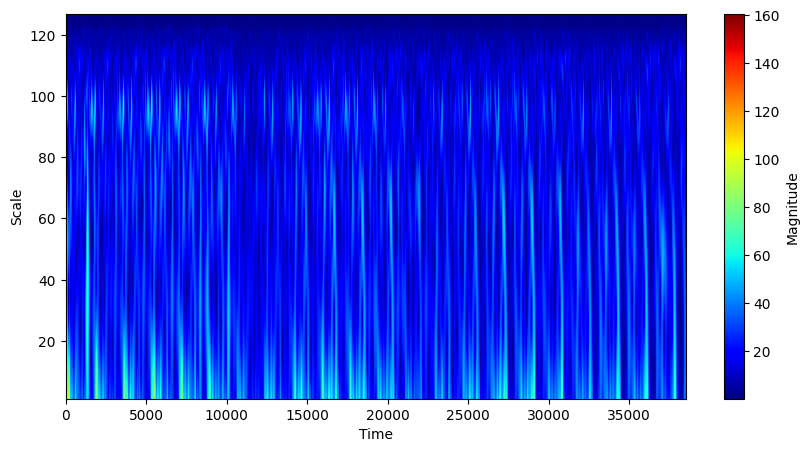

In [ ]:
wavelet = 'morl'

scales = np.arange(1, 128)

coefficients, frequencies = pywt.cwt(eeg_data, scales, wavelet)

plt.figure(figsize=(10, 5))
plt.imshow(np.abs(coefficients), aspect='auto', extent=[0, len(eeg_data), min(scales), max(scales)], cmap='jet')
plt.colorbar(label='Magnitude')
plt.xlabel('Time')
plt.ylabel('Scale')
plt.show()


In [ ]:
for trial,eeg_data in enumerate(X):

    wavelet = 'morl'

    scales = np.arange(1, 128)
    coefficients, frequencies = pywt.cwt(eeg_data, scales, wavelet)

    title = '/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/MotorImagery_IV/Dataset/Scalograms/{:02d}_trial_'.format(int(1))
    title = title+'{:02d}'.format(int(trial))
    # title = title+'__{:1d}.png'.format(int(y_[trial]))

    if (int(y[trial]) == 1):
      title += '__class01.png'
    elif (int(y[trial]) == 2):
      title += '__class02.png'
    elif (int(y[trial]) == 3):
      title += '__class03.png'
    elif (int(y[trial]) == 4):
      title += '__class04.png'
    else:
      print("ERROR: UNKNOWN CLASS IN TRIAL: " . trial)
      continue


    # plt.imsave(title, np.abs(coefficients), cmap='jet')


    plt.figure(figsize=(10, 5))
    plt.imshow(np.abs(coefficients), aspect='auto', extent=[0, len(eeg_data), min(scales), max(scales)], cmap='jet')
    plt.colorbar(label='Magnitude')
    plt.xlabel('Time')
    plt.ylabel('Scale')
    plt.savefig(title, dpi=300, bbox_inches='tight')
    plt.show()




# **Transfer Learning**

In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

In [ ]:
import torch
import torchvision.models as models

resnet_model = models.resnet50(pretrained=True)

for param in resnet_model.parameters():
    param.requires_grad = False

print(resnet_model)


In [ ]:
num_classes = 4
resnet_model.fc = torch.nn.Linear(resnet_model.fc.in_features, num_classes)


In [ ]:
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [ ]:
import os
import numpy as np
from PIL import Image
from google.colab import drive
import matplotlib.pyplot as plt


drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def load_images_and_labels(folder_path):
    images = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):

            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            image = image.convert("RGB")

            image = image.resize((224,224))
            image_array = np.array(image) / 255.0
            images.append(image_array)

            if ("class01" in filename) :
                labels.append(0)
            elif "class02" in filename:
                labels.append(1)
            elif "class03" in filename:
                labels.append(2)
            elif "class04" in filename:
                labels.append(3)
            else:
                raise ValueError("Invalid filename format")

    return np.array(images), np.array(labels)

In [ ]:
folder_path = '/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/MotorImagery_IV/Dataset/Scalograms/'
X, Y = load_images_and_labels(folder_path)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (553, 224, 224, 3)
Shape of Y: (553,)


In [ ]:
Y

array([2, 1, 0, 0, 1, 2, 3, 1, 2, 0, 0, 0, 3, 1, 1, 0, 0, 2, 0, 1, 3, 2,
       0, 3, 3, 1, 3, 3, 1, 0, 1, 2, 2, 2, 3, 2, 0, 3, 1, 2, 1, 2, 3, 2,
       0, 0, 0, 3, 1, 2, 0, 2, 3, 0, 2, 2, 0, 2, 1, 3, 3, 3, 0, 3, 1, 3,
       1, 0, 2, 1, 0, 2, 2, 0, 2, 3, 3, 1, 0, 1, 3, 1, 3, 2, 1, 1, 1, 2,
       0, 1, 2, 2, 3, 0, 0, 1, 3, 3, 3, 1, 0, 2, 1, 3, 0, 3, 2, 1, 3, 3,
       0, 1, 1, 2, 3, 1, 0, 0, 3, 1, 0, 2, 1, 1, 2, 0, 3, 2, 2, 2, 2, 0,
       1, 0, 1, 0, 0, 2, 2, 1, 2, 3, 0, 3, 0, 0, 1, 3, 2, 1, 3, 2, 3, 2,
       3, 1, 1, 3, 0, 1, 1, 1, 2, 3, 0, 3, 0, 2, 0, 3, 0, 2, 0, 1, 2, 2,
       3, 0, 1, 3, 1, 2, 0, 3, 1, 3, 0, 0, 2, 2, 1, 3, 1, 1, 0, 1, 3, 3,
       1, 1, 1, 1, 3, 2, 3, 0, 1, 2, 1, 0, 3, 0, 3, 0, 0, 0, 0, 2, 3, 1,
       2, 2, 2, 3, 2, 0, 2, 0, 3, 1, 3, 3, 2, 3, 3, 2, 1, 3, 2, 0, 1, 1,
       2, 1, 3, 2, 3, 1, 2, 0, 3, 0, 2, 3, 0, 2, 0, 1, 1, 0, 3, 0, 2, 2,
       0, 2, 1, 1, 0, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 2, 1, 3, 0, 2, 1, 0,
       3, 3, 3, 3, 2, 1, 0, 0, 2, 3, 0, 2, 2, 2, 0,

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images here i used imagenet stats
])


In [ ]:
import numpy as np

# Generate a random permutation of indices
indices = np.random.permutation(len(X))

# Shuffle both x and y using the same indices
X = X[indices]
Y = Y[indices]


In [ ]:
# Create dataset
dataset = CustomDataset(X, Y, transform=transform)

# Define data loader
batch_size = 16

# Split the dataset into training and testing subsets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
len(dataset)

553

In [ ]:
num_epochs = 20
for epoch in range(num_epochs):
    # Training loop
    resnet_model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = resnet_model(images.float())
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation loop
    resnet_model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for images, labels in test_loader:
            outputs = resnet_model(images.float())
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
        accuracy = total_correct / total_samples
        print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f}')




Epoch [1/20], Accuracy: 0.1892
Epoch [2/20], Accuracy: 0.2523
Epoch [3/20], Accuracy: 0.3063
Epoch [4/20], Accuracy: 0.2432
Epoch [5/20], Accuracy: 0.2703
Epoch [6/20], Accuracy: 0.2613
Epoch [7/20], Accuracy: 0.2793


KeyboardInterrupt: 

In [ ]:
for images, labels in train_loader:
  print(type(images))
  print(images)


In [ ]:
print(type(test_dataset[0][0]))
test_dataset[0][0]

In [ ]:
resnet_model.eval()
with torch.no_grad():
    image = test_dataset[3][0]
    label = test_dataset[3][1]
    image = image.view(1, 3, 224, 224)
    output = resnet_model(image.float())
    _, predicted = torch.max(output, 1)
    print("Label = ", label, "\nPredicted = ", predicted[0])

In [ ]:
X_class0 = []
X_class1 = []
X_class2 = []
X_class3 = []

for i in range(len(X)):
  if (Y[i] == 0):
    X_class0.append(i)
  elif (Y[i] == 1):
    X_class1.append(i)
  elif (Y[i] == 2):
    X_class2.append(i)
  elif (Y[i] == 3):
    X_class3.append(i)

In [ ]:
X_class1

[0,
 3,
 12,
 19,
 25,
 26,
 30,
 31,
 38,
 41,
 49,
 51,
 55,
 61,
 63,
 64,
 70,
 71,
 73,
 81,
 83,
 90,
 91,
 94,
 95,
 98,
 100,
 110,
 113,
 115,
 129,
 130,
 131,
 141,
 142,
 145,
 147,
 148,
 153,
 158,
 165,
 167,
 170,
 182,
 186,
 188,
 193,
 196,
 197,
 201,
 232,
 235,
 237,
 240,
 241,
 242,
 243,
 252,
 256,
 257,
 260,
 261,
 267,
 268,
 270,
 273,
 279,
 291,
 295,
 304,
 310,
 312,
 314,
 315,
 318,
 326,
 332,
 341,
 345,
 348,
 351,
 352,
 353,
 354,
 359,
 360,
 362,
 365,
 366,
 368,
 371,
 380,
 382,
 384,
 387,
 391,
 393,
 398,
 402,
 408,
 411,
 413,
 414,
 415,
 419,
 423,
 427,
 428,
 432,
 435,
 436,
 438,
 441,
 444,
 454,
 463,
 465,
 473,
 475,
 479,
 489,
 495,
 502,
 509,
 511,
 512,
 513,
 521,
 524,
 525,
 527,
 529,
 533,
 536,
 538,
 541,
 544,
 546,
 549]

In [ ]:
Y

array([1, 0, 0, 1, 3, 3, 3, 3, 0, 2, 2, 0, 1, 0, 3, 3, 2, 0, 3, 1, 3, 2,
       0, 0, 0, 1, 1, 2, 3, 0, 1, 1, 2, 3, 2, 3, 2, 0, 1, 3, 3, 1, 2, 3,
       3, 3, 0, 0, 3, 1, 0, 1, 0, 2, 2, 1, 0, 2, 3, 0, 2, 1, 2, 1, 1, 3,
       0, 3, 3, 2, 1, 1, 0, 1, 0, 3, 3, 0, 0, 0, 2, 1, 0, 1, 0, 2, 2, 2,
       2, 2, 1, 1, 3, 0, 1, 1, 3, 0, 1, 3, 1, 2, 3, 2, 2, 3, 2, 3, 0, 3,
       1, 3, 3, 1, 0, 1, 2, 0, 3, 2, 3, 2, 2, 2, 0, 3, 0, 0, 0, 1, 1, 1,
       0, 3, 0, 3, 2, 3, 0, 3, 3, 1, 1, 2, 2, 1, 3, 1, 1, 3, 2, 0, 2, 1,
       2, 2, 3, 3, 1, 0, 3, 0, 0, 2, 2, 1, 2, 1, 0, 0, 1, 3, 0, 0, 2, 2,
       0, 3, 0, 2, 3, 2, 1, 0, 3, 2, 1, 3, 1, 0, 2, 2, 2, 1, 3, 0, 1, 1,
       3, 0, 2, 1, 2, 2, 3, 2, 0, 2, 0, 3, 3, 0, 2, 3, 2, 3, 2, 2, 0, 0,
       3, 3, 3, 2, 0, 2, 2, 3, 3, 3, 2, 3, 1, 0, 2, 1, 3, 1, 0, 0, 1, 1,
       1, 1, 0, 3, 2, 2, 0, 0, 2, 0, 1, 3, 3, 3, 1, 1, 3, 0, 1, 1, 2, 3,
       2, 3, 0, 1, 1, 2, 1, 2, 2, 1, 2, 2, 3, 3, 2, 1, 3, 3, 0, 3, 2, 0,
       3, 0, 3, 0, 3, 1, 3, 2, 3, 1, 0, 2, 2, 0, 2,

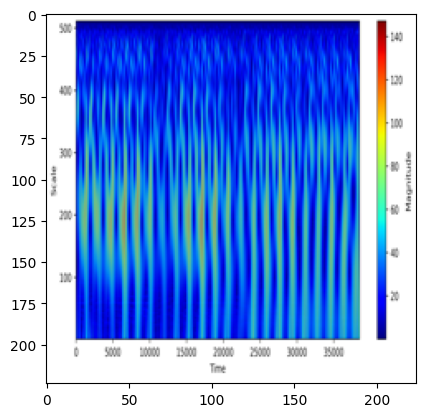

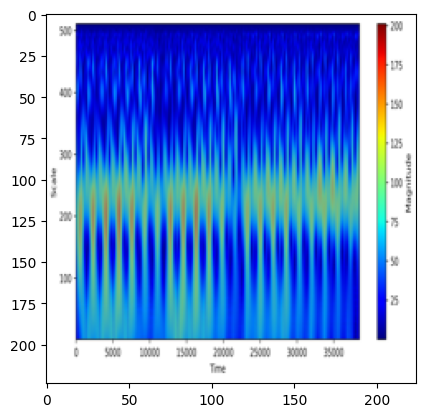

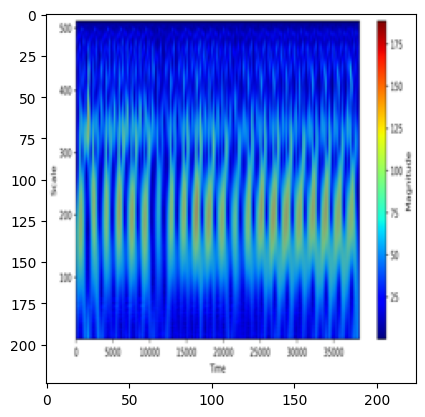

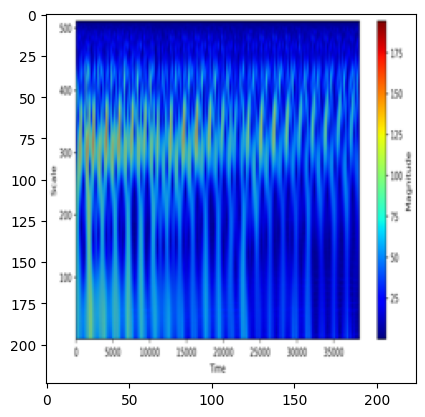

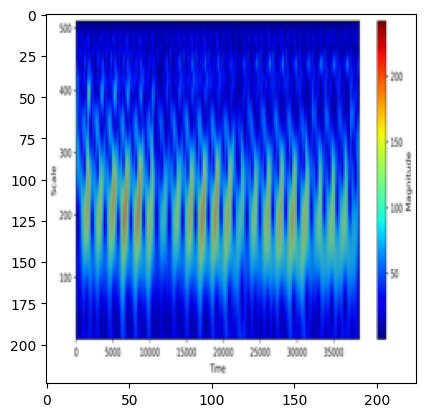

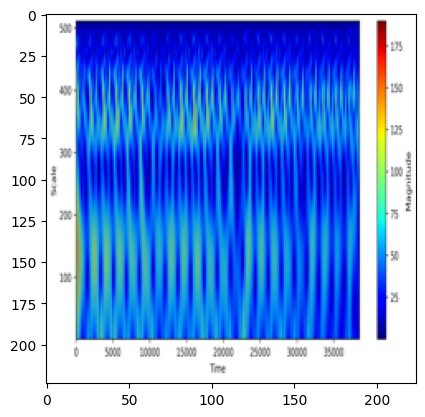

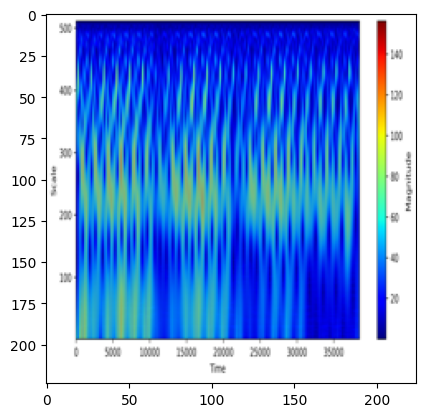

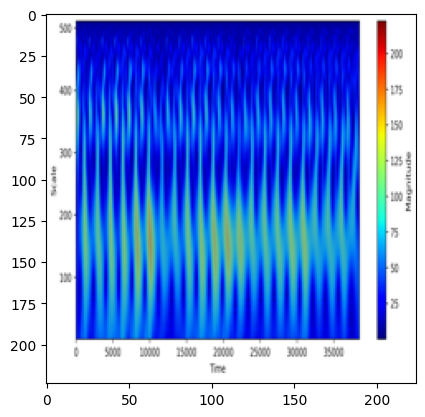

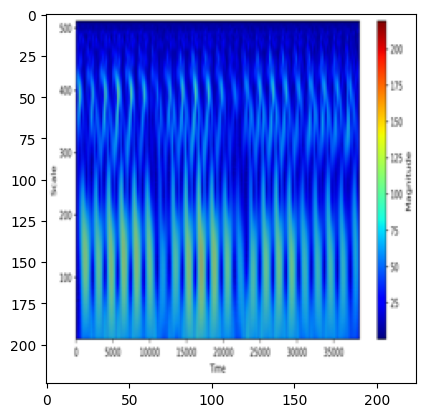

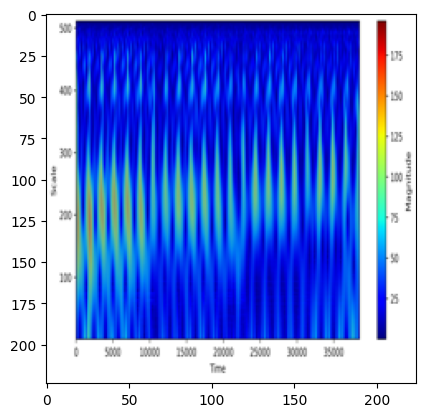

In [ ]:
for i in X_class0[:10]:
  plt.imshow(X[i])
  plt.show()

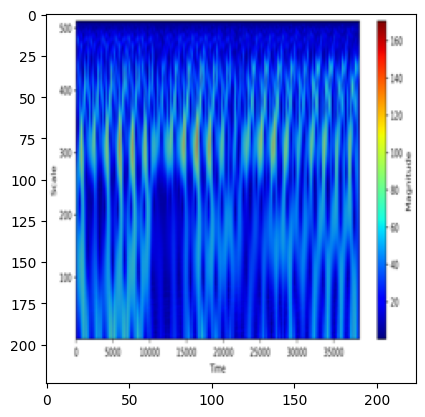

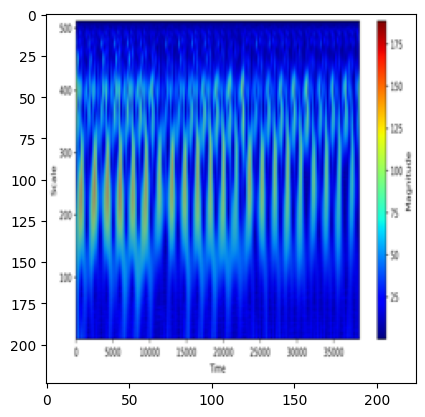

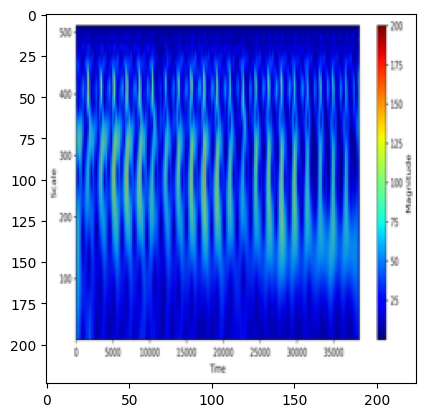

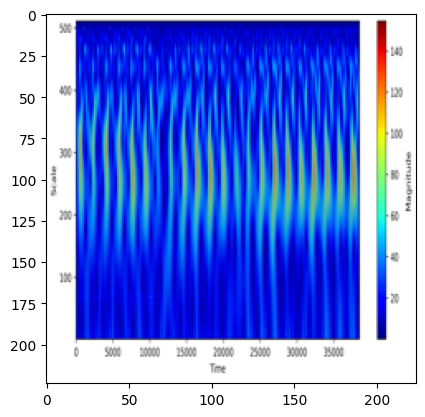

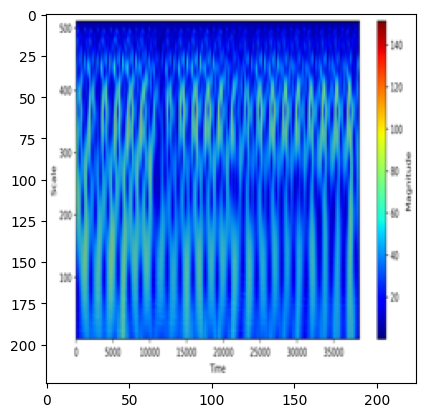

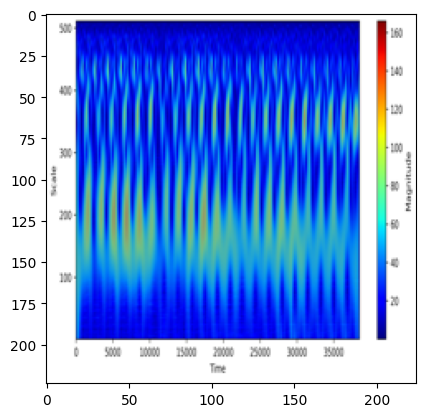

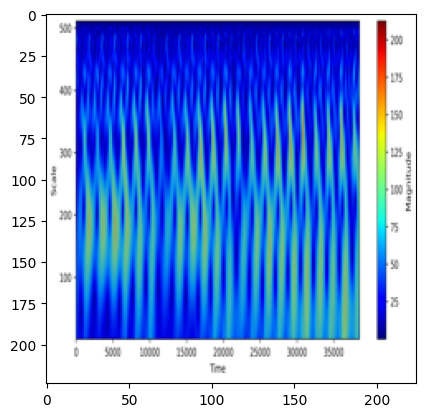

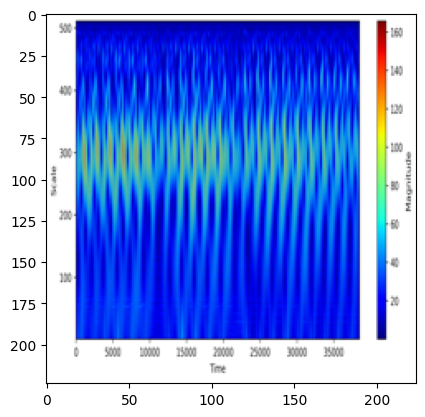

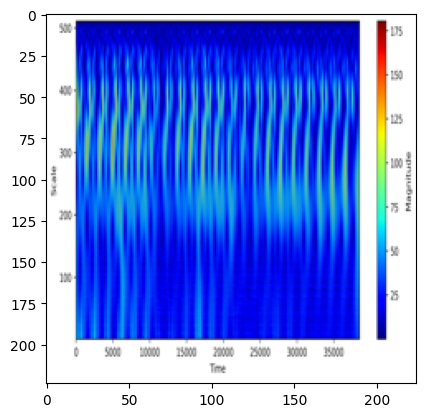

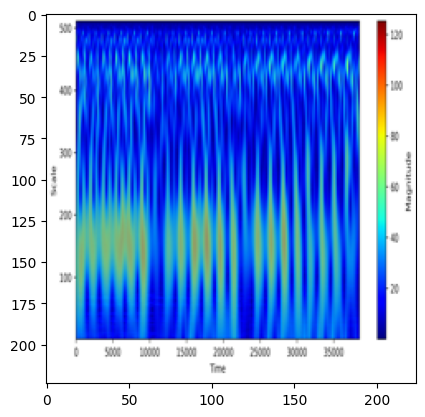

In [ ]:
for i in X_class1[:10]:
  plt.imshow(X[i])
  plt.show()

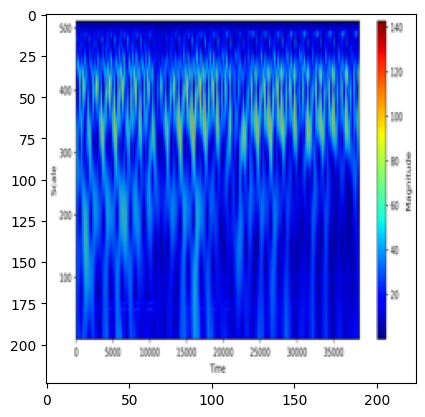

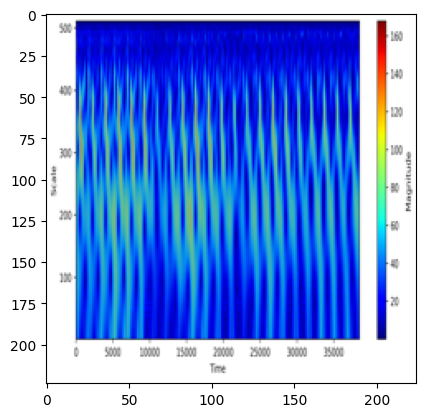

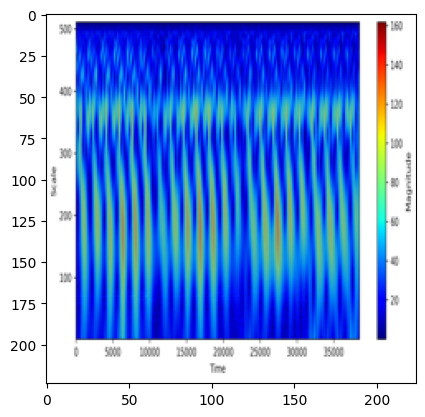

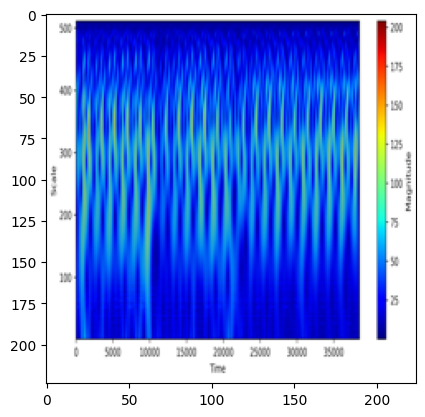

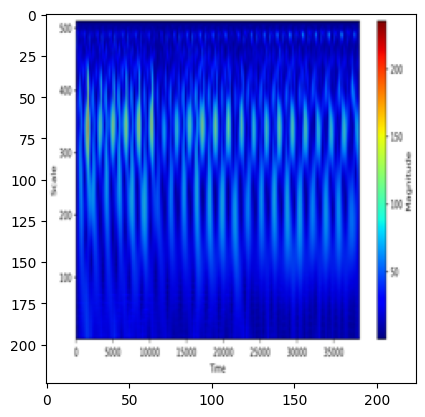

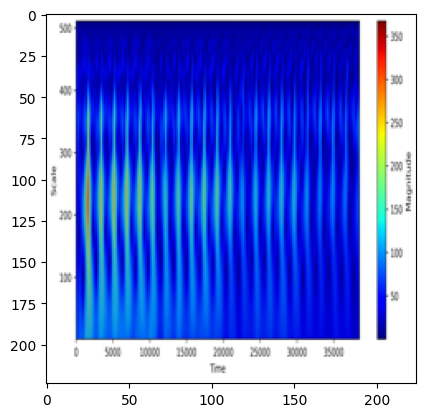

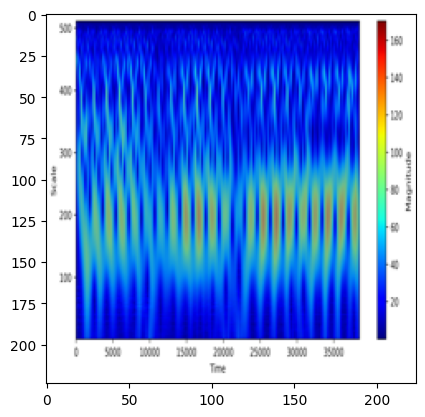

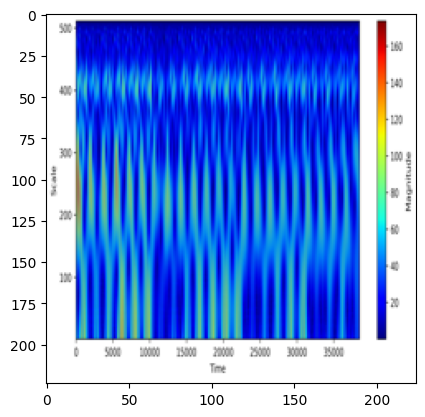

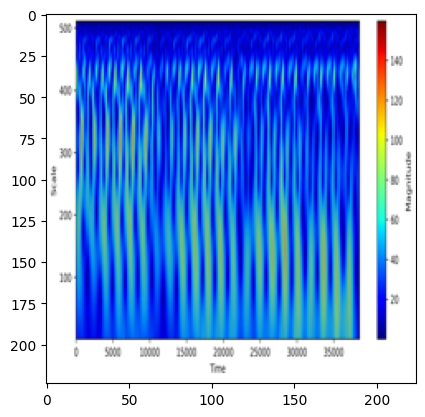

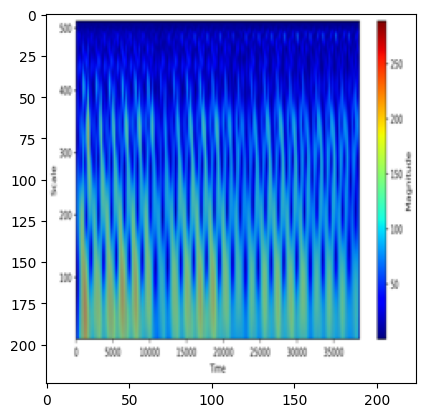

In [ ]:
for i in X_class2[:10]:
  plt.imshow(X[i])
  plt.show()

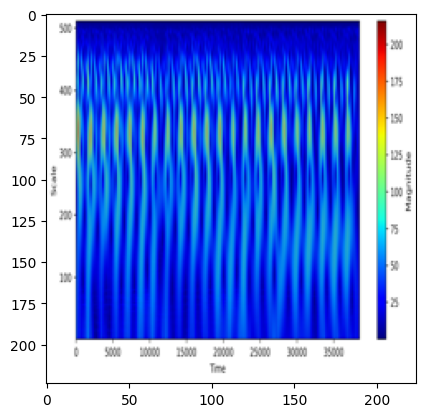

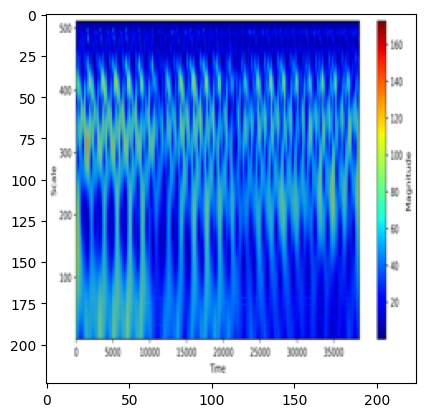

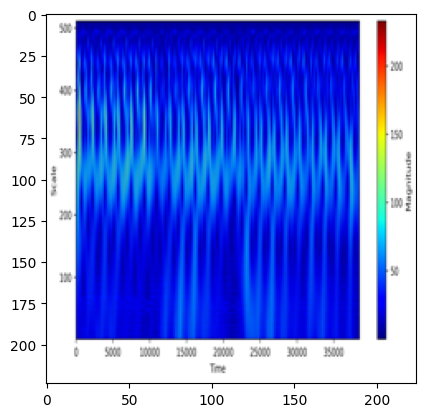

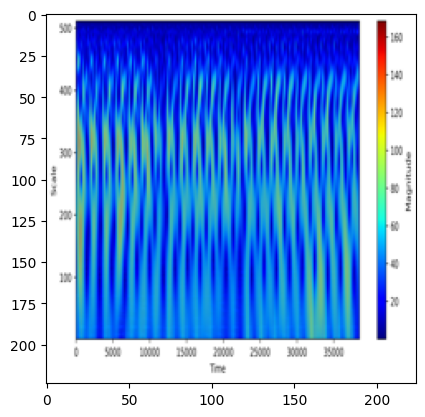

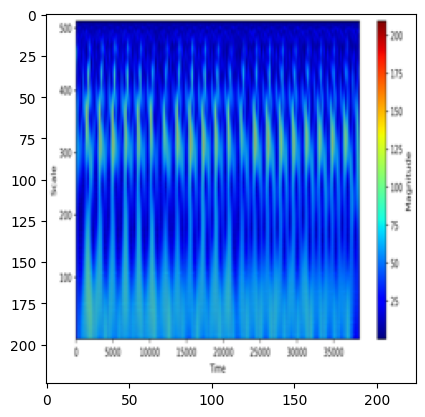

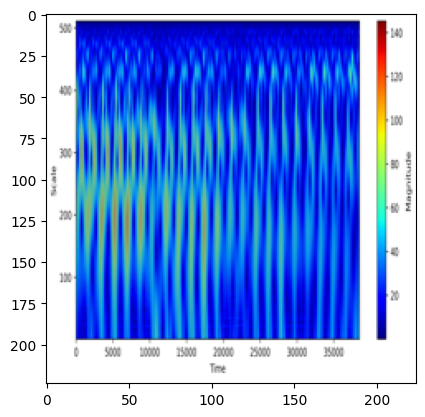

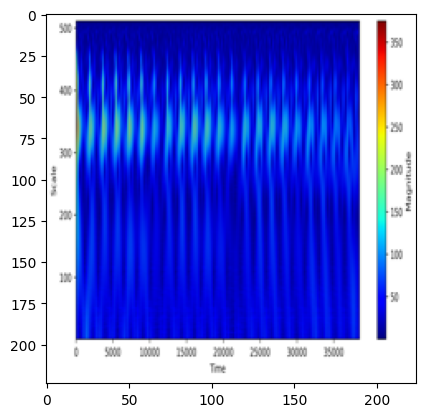

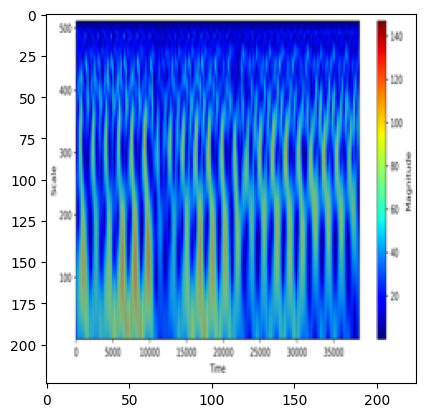

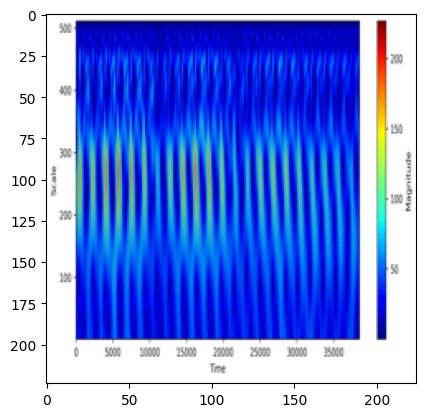

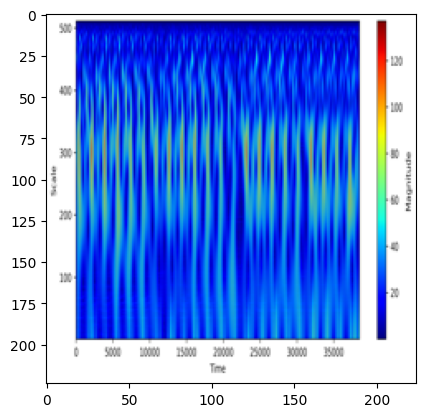

In [ ]:
for i in X_class3[:10]:
  plt.imshow(X[i])
  plt.show()